In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from random import sample
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score, roc_auc_score, roc_curve, cohen_kappa_score, brier_score_loss
from sklearn.metrics import matthews_corrcoef

In [2]:
data = pd.read_csv("dat_15-09-2022_morgan_chiral_2048FP.csv")
#data

In [3]:
df = pd.DataFrame(data)
df.reset_index(drop=True, inplace=True)

In [4]:
y= df.Target
X=df.drop('Target', axis=1)

In [5]:
cat_features=list(range(0,X.shape[1]))

In [6]:
df.Target.value_counts()

0    1109
1    1102
Name: Target, dtype: int64

In [7]:
y_train = df.Target
x_train = df.drop('Target', axis=1)

In [8]:
#transpose matrices
x_train = x_train.T
y_train = y_train.T

In [9]:
y_train.value_counts()

0    1109
1    1102
Name: Target, dtype: int64

In [10]:
#Read the validation set
v_test_data = pd.read_csv("val_15-09-2022_morgan_chiral_2048FP.csv")
v_test_data = pd.DataFrame(v_test_data)
v_test_data.shape

(367, 2049)

In [11]:
Y_v_test_data = v_test_data.Target
X_v_test_data = v_test_data.drop('Target', axis=1)

In [12]:
import xgboost as xgb
#Parameters for descriptor
#ens = xgb.XGBRFClassifier(
#    colsample_bylevel= 0.8,
#    colsample_bytree= 0.2,
#    learning_rate= 0.0001,
#    max_delta_step= 5,
#    max_depth= 10,
#    n_estimators= 4000,
#    objective= 'binary:logistic',
#    subsample= 0.1
#)
#Parameters for 1024, 2048 fp
ens = xgb.XGBRFClassifier(
    colsample_bylevel= 0.8,
    colsample_bytree= 0.2,
    learning_rate= 0.0001,
    max_delta_step= 5,
    max_depth= 10,
    n_estimators= 4000,
    objective= 'binary:logistic',
    subsample= 0.1
)
ens.fit(x_train.T, y_train.T)

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
                colsample_bytree=0.2, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.0001, max_delta_step=5, max_depth=10,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=4000, n_jobs=0, num_parallel_tree=4000,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1, subsample=0.1, tree_method='exact',
                validate_parameters=1, verbosity=None)

In [13]:
v_predictions = ens.predict(X_v_test_data)
acc_train=ens.score(x_train.T,y_train.T)*100
v_acc_test = ens.score(X_v_test_data, Y_v_test_data)*100
print(acc_train)
print(v_acc_test)

72.68204432383537
68.11989100817438


In [14]:
from sklearn.metrics import matthews_corrcoef
print('Accuracy:%0.3f'% v_acc_test)
tn, fp, fn, tp = confusion_matrix(Y_v_test_data, v_predictions).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity:%0.3f'% sensitivity)
print('Specificity:%0.3f'% specificity)
ba = 0.5 * (sensitivity + specificity)
print('Balance accuracy:%0.3f'% ba)
mcc = matthews_corrcoef(Y_v_test_data, v_predictions)
#mcc = matthews_corrcoef(Y_test_data, v_predictions)
print('MCC: %0.3f'% mcc)
r_auc_score = roc_auc_score(Y_v_test_data, v_predictions)
#r_auc_score = roc_auc_score(Y_test_data, v_predictions)
print('AUC: %0.3f' % r_auc_score)
bloss = brier_score_loss(Y_v_test_data, v_predictions)
#bloss = brier_score_loss(Y_test_data, v_predictions)
print('Brier_loss: %0.3f' % bloss)
FPR = fp/(fp+tn)
FNR = fn/(tp+fn)
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)
print('False Postive rate: %0.3f' %FPR)
print('False Negative rate: %0.3f' %FNR)
print('Precision: %0.3f' %Precision)
print('Recall: %0.3f' %Recall)
f1=2*((Precision*Recall)/(Precision+Recall))
print('F1: %0.3f' %f1)
#kappa = cohen_kappa_score(Y_test_data, v_predictions)
kappa = cohen_kappa_score(Y_v_test_data, v_predictions)
print('Kappa: %0.3f' %kappa)

Accuracy:68.120
Sensitivity:0.597
Specificity:0.722
Balance accuracy:0.659
MCC: 0.307
AUC: 0.659
Brier_loss: 0.319
False Postive rate: 0.278
False Negative rate: 0.403
Precision: 0.507
Recall: 0.597
F1: 0.548
Kappa: 0.304


In [15]:
cf =(confusion_matrix(Y_v_test_data, v_predictions))
print(classification_report(Y_v_test_data, v_predictions))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       248
           1       0.51      0.60      0.55       119

    accuracy                           0.68       367
   macro avg       0.65      0.66      0.65       367
weighted avg       0.70      0.68      0.69       367



<AxesSubplot:xlabel='Predicted Value', ylabel='True Value'>

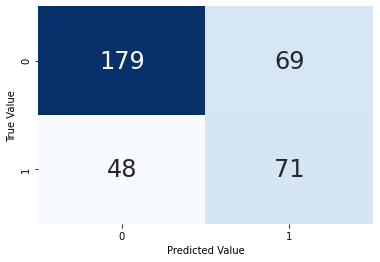

In [16]:
cf_plt =sns.heatmap(cf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
cf_plt.set(xlabel = "Predicted Value", ylabel ="True Value")
cf_plt

In [18]:
r_probs = [0 for _ in range(len(Y_v_test_data))]
ens_prob = ens.predict_proba(X_v_test_data)
ens_prob = ens_prob[:,1]
#ens_prob

In [19]:
prediction_val=ens.predict(X_v_test_data)

In [20]:
prediction_val=pd.DataFrame(prediction_val)

In [21]:
prediction_val.to_csv("ENS_2048_Valitation_Prediction.csv")

In [23]:
r_auc_score = roc_auc_score(Y_v_test_data, ens_prob)
r_auc_score_1 = roc_auc_score(Y_v_test_data,r_probs)
print(r_auc_score)
fpr, tpr, _ = roc_curve(Y_v_test_data, ens_prob)
rfpr, rtpr, _ = roc_curve(Y_v_test_data, r_probs)

0.6960219571699646


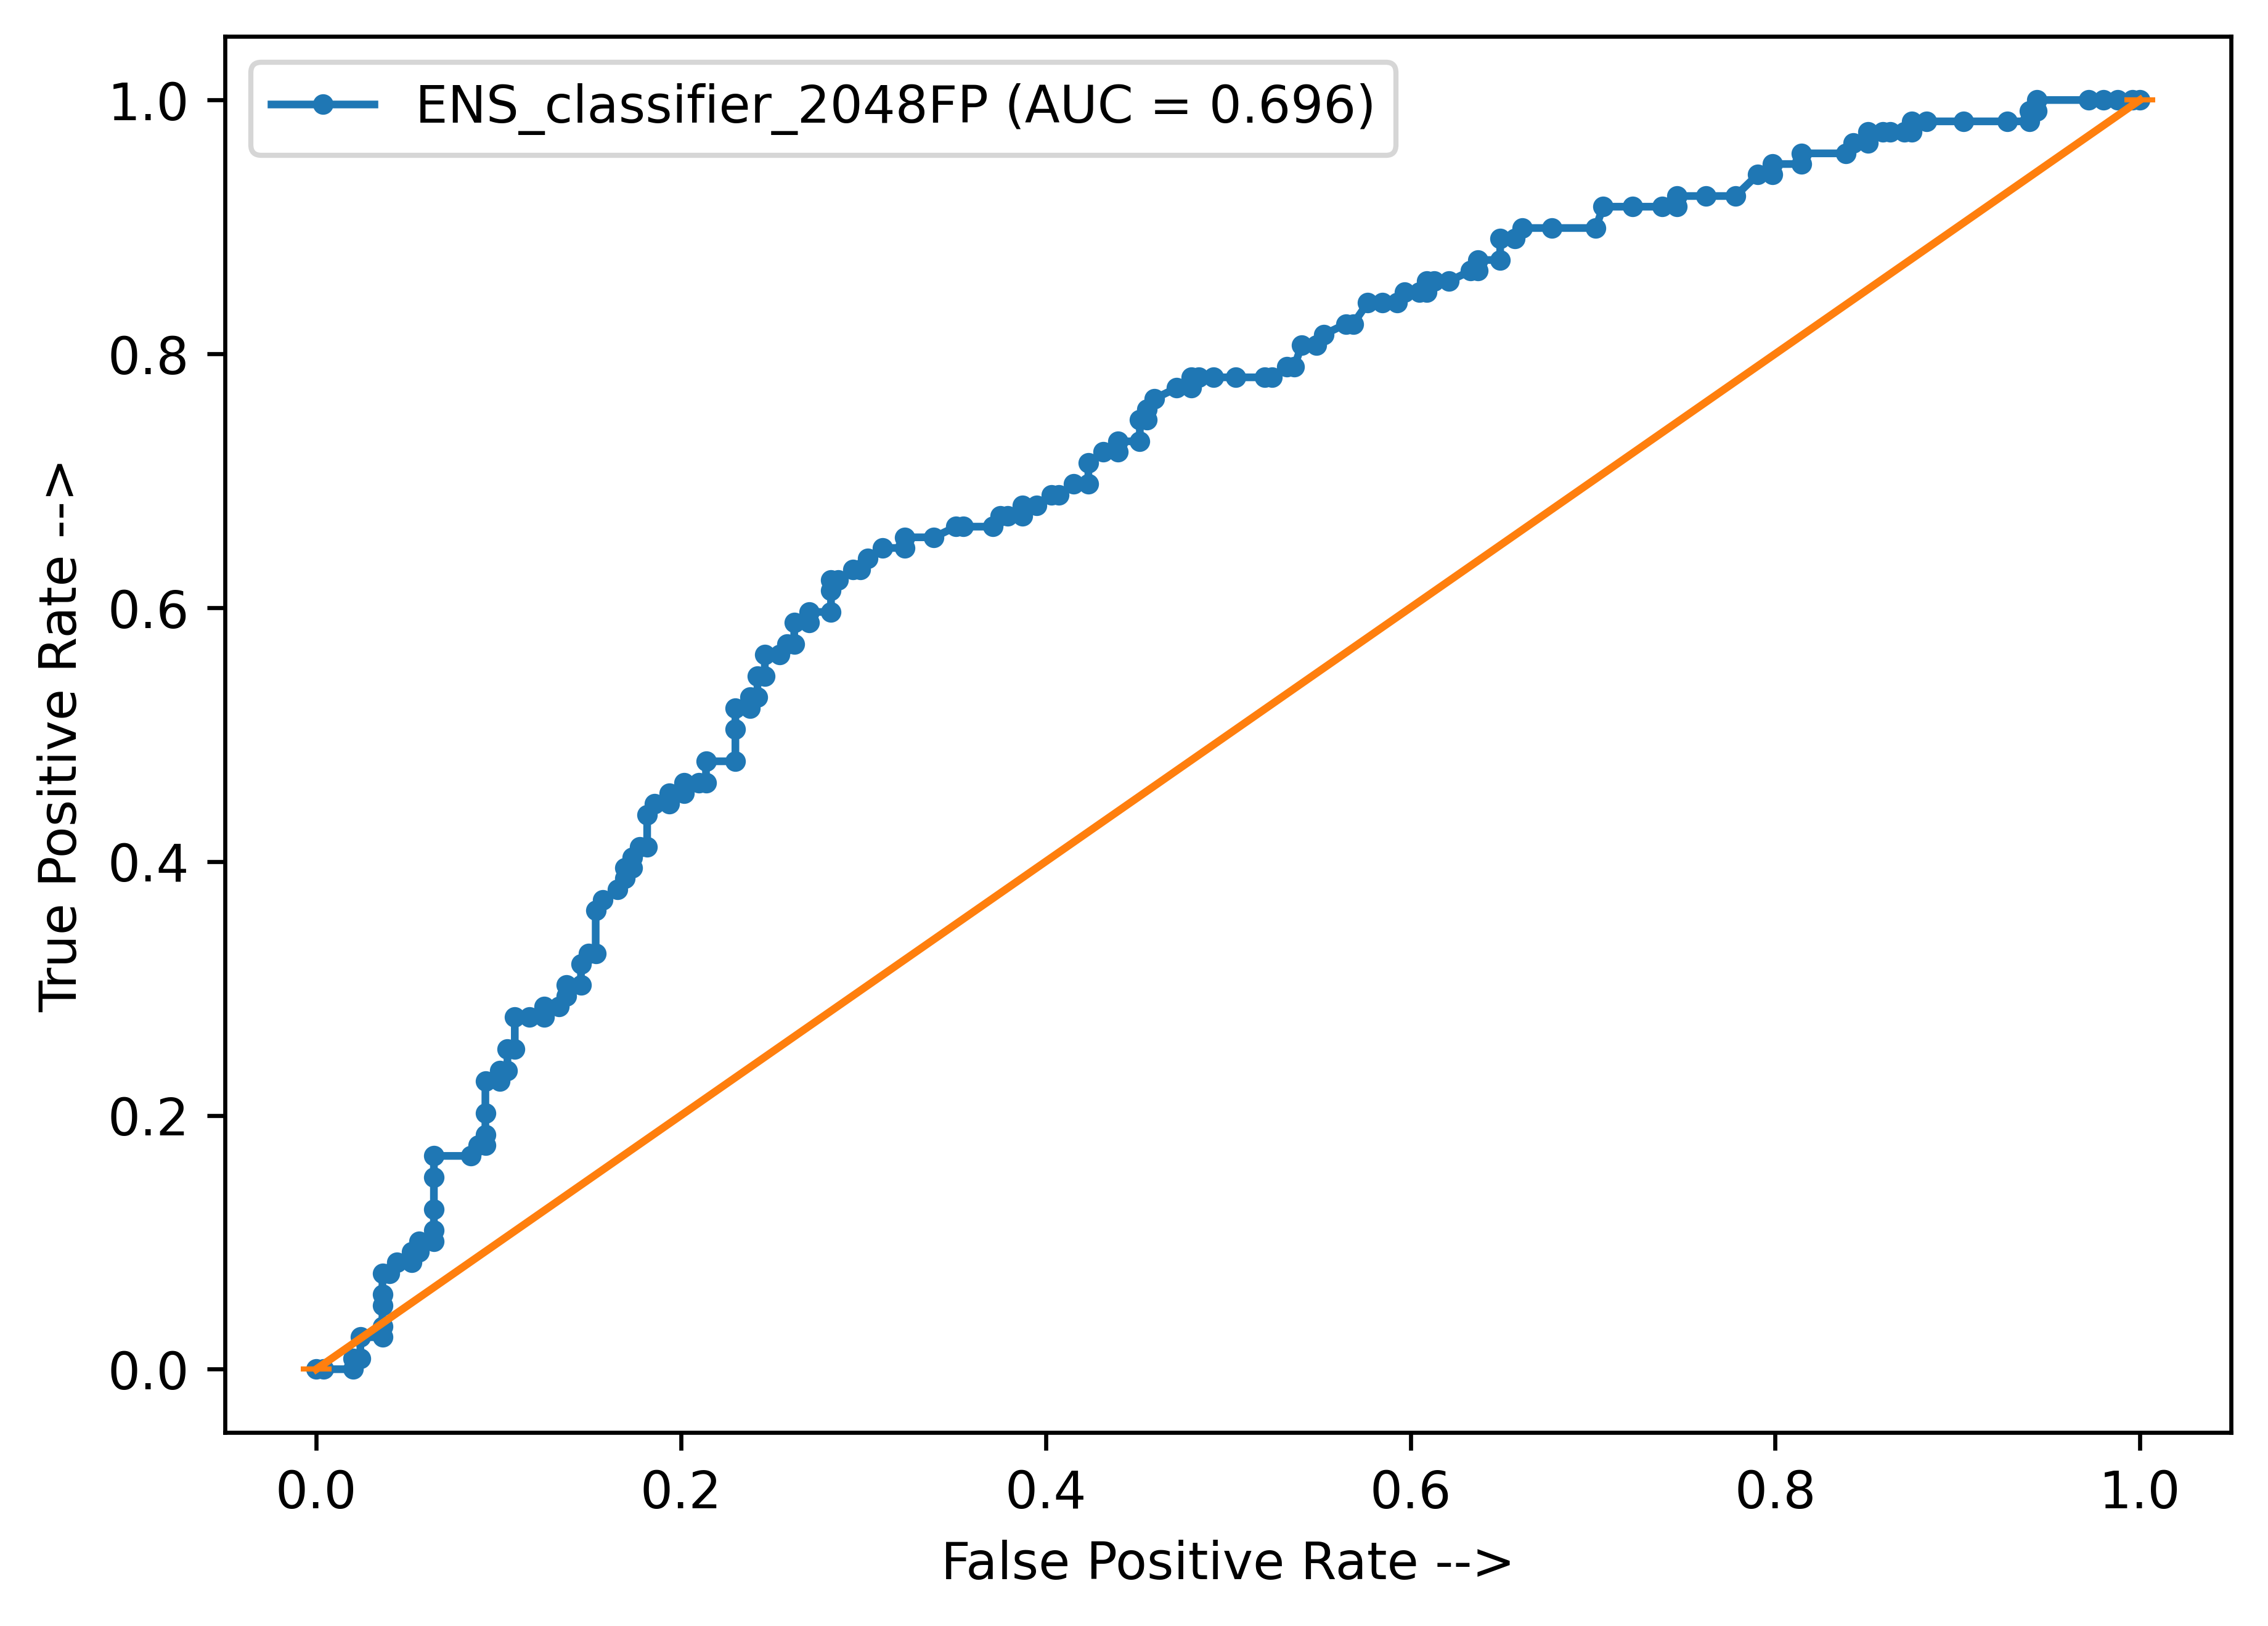

In [24]:
plt.figure(figsize=(7, 5), dpi=600)
plt.plot(fpr, tpr, marker='.', label='ENS_classifier_2048FP (AUC = %0.3f)' % r_auc_score)
plt.plot(rfpr, rtpr, marker='_' % r_auc_score_1)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()
#plt.savefig('XGB_AUC.png', dpi=600, bbox_inches='tight')

In [25]:
#Read external set
external_data = pd.read_csv("cyclic_ind_16-09-2022_morgan_chiral_2048FP.csv")
data_for_screening = pd.DataFrame(external_data)
#data_for_screening

In [26]:
#test external data
test_prob = ens.predict_proba(data_for_screening)
test_prob_F = pd.DataFrame(test_prob)
test_prob_F.to_csv('ENS_2048FP_External_probability.csv')

In [27]:
prediction_ext=ens.predict(data_for_screening)
prediction_ext=pd.DataFrame(prediction_ext)
prediction_ext.to_csv("ENS_2048_External_Prediction.csv")

In [ ]:
##Plotting the Mean AUC

In [28]:
from sklearn.metrics import RocCurveDisplay

In [29]:
from scipy import interp
from sklearn.metrics import roc_curve,auc
cv = StratifiedKFold(n_splits=10,shuffle=False)

<ipython-input-30-6fa63cd1c773>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-30-6fa63cd1c773>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-30-6fa63cd1c773>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-30-6fa63cd1c773>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-30-6fa63cd1c773>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-30-6fa63cd1c773>:13: DeprecationWarning: scipy.interp i

<Figure size 4200x3000 with 0 Axes>

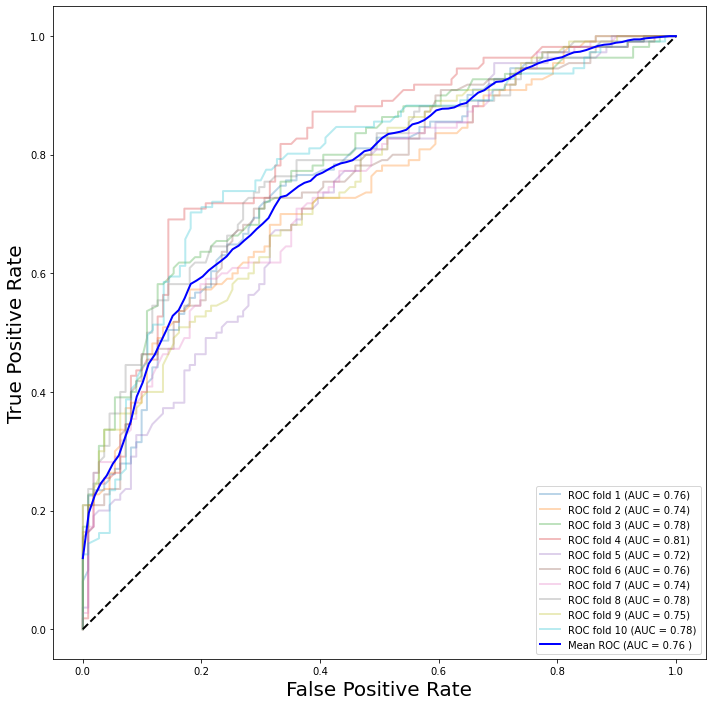

In [30]:
# plot k fold ROC
plt.figure(figsize=(7, 5), dpi=600)
x_train = x_train.T
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x_train,y_train):
    prediction = ens.fit(x_train.iloc[train],y_train.iloc[train]).predict_proba(x_train.iloc[test])
    fpr, tpr, t = roc_curve(y_train.iloc[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.legend(loc="lower right")
plt.show()
#plt.savefig('CrossVal-AUC_CB_1024.png', dpi=600, bbox_inches='tight')

In [ ]:
## Y Randomization

In [31]:
accuracy_list = []
for i in range(50):
    y_train = y_train.sample(frac=1, replace=False, random_state=i)
    ens.fit(x_train, y_train)
    scrmb_predictions = ens.predict(X_v_test_data)
    print(i)
    accuracy = roc_auc_score(Y_v_test_data, scrmb_predictions)
    accuracy_list.append(accuracy)
print
accuracy_list

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


[0.556892111683383,
 0.5925047438330171,
 0.608464353483329,
 0.4491562754133912,
 0.47536595283274596,
 0.4878015722417999,
 0.5017619951206289,
 0.5467945242613174,
 0.5745290051504474,
 0.4600840336134454,
 0.436212388181079,
 0.49552724315532665,
 0.39975264299268093,
 0.4295032529140688,
 0.545608566007048,
 0.6190532664678775,
 0.49688262401734884,
 0.5730042016806722,
 0.4449545947411222,
 0.49891569531038216,
 0.5188906207644348,
 0.5605855245323936,
 0.4578984819734345,
 0.39001084304689615,
 0.5357142857142857,
 0.4392450528598536,
 0.6126660341555978,
 0.5143500948766603,
 0.5084880726484142,
 0.4432773109243697,
 0.4136961236107346,
 0.5501660341555977,
 0.47033410138248843,
 0.5973841149362971,
 0.5007624017348875,
 0.4898346435348333,
 0.5568751694226077,
 0.5105042016806722,
 0.44764841420439144,
 0.4891569531038222,
 0.4061398753049607,
 0.4132047980482515,
 0.48898753049606936,
 0.5024227432908648,
 0.5115037950664137,
 0.5308349146110056,
 0.38177690431011113,
 0.4562

/home/acdsd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 1.0)]

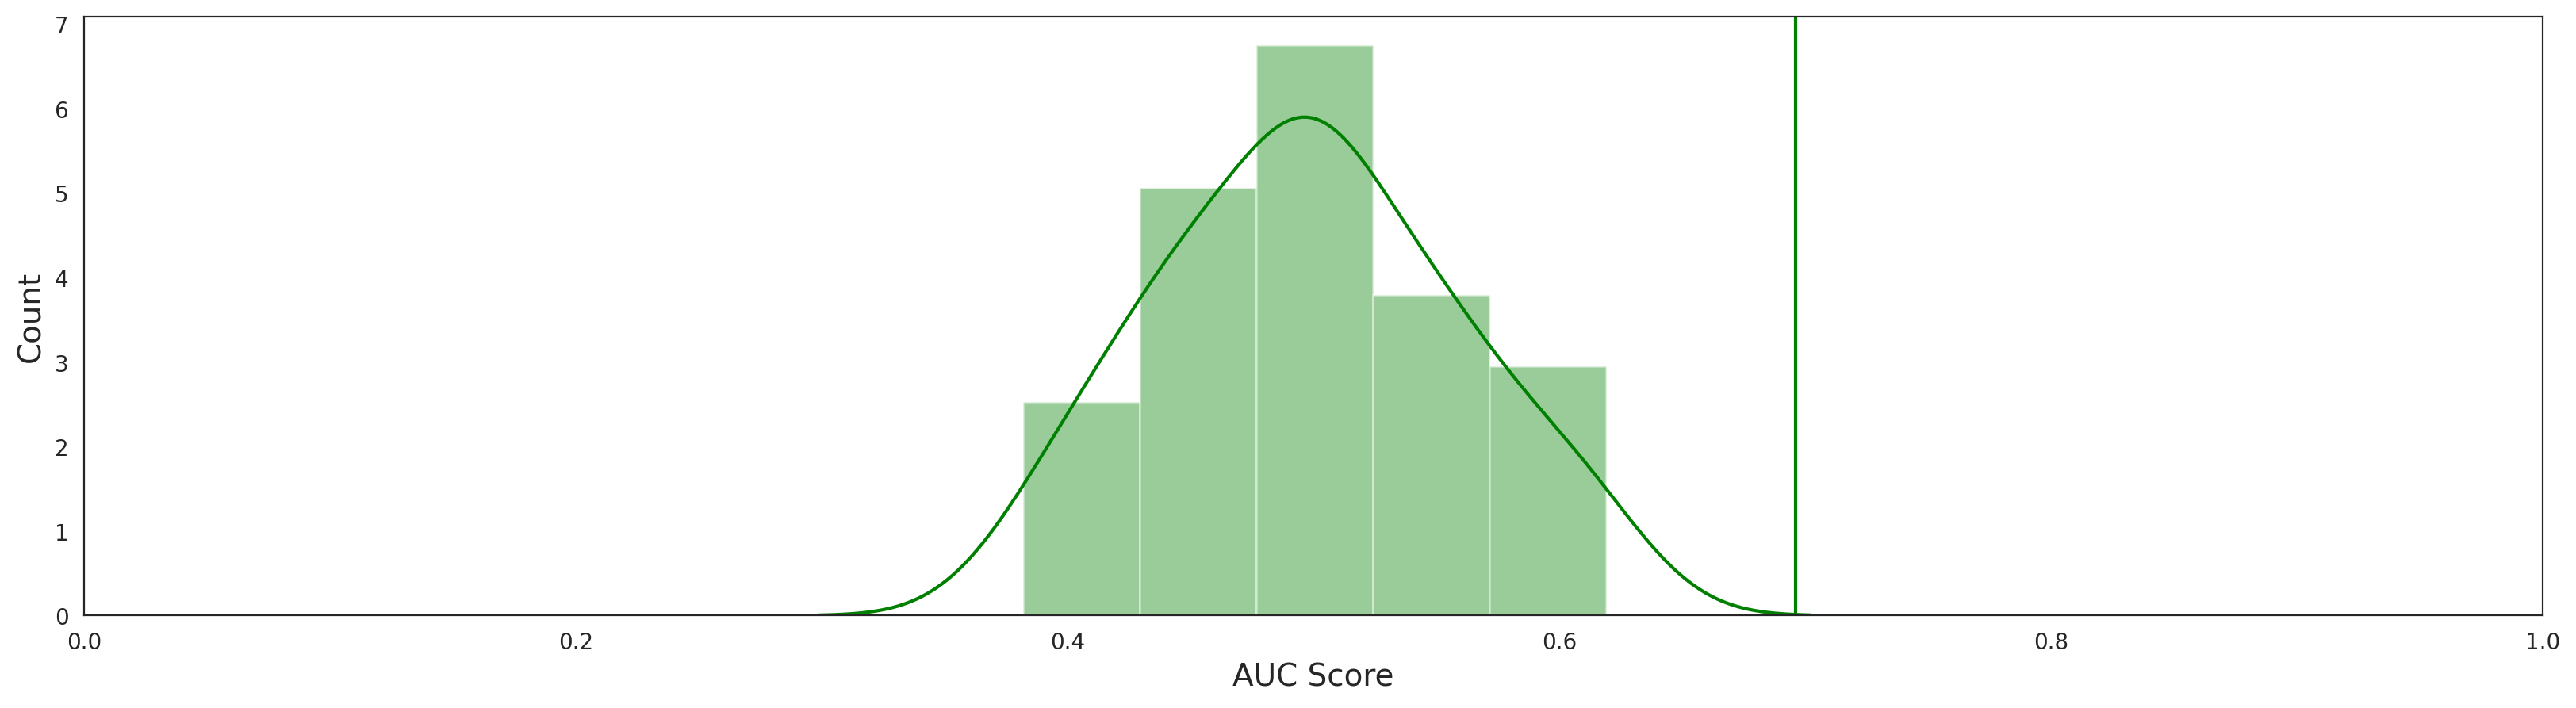

In [32]:
r_auc_score2 = roc_auc_score(Y_v_test_data, scrmb_predictions)
sns.set_style("white")
plt.figure(figsize = (20, 5), dpi=200) 
ax = sns.distplot(accuracy_list, color="green")
plt.axvline(r_auc_score, color="green")
plt.xlabel("AUC Score", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
ax.set(xlim=(0, 1))
#plt.savefig('CatBoost_scrambling_plot.png', dpi=600, bbox_inches='tight')

In [33]:
mcc_list = []
for i in range(50):
    y_train = y_train.sample(frac=1, replace=False, random_state=i)
    ens.fit(x_train, y_train)
    scrmb_predictions = ens.predict(X_v_test_data)
    print(i)
    mcc_v = matthews_corrcoef(Y_v_test_data, scrmb_predictions)
    mcc_list.append(mcc_v)
mcc_list

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


[0.12288626446650694,
 -0.0902516423675028,
 -0.062144208145111623,
 0.1699739438097293,
 -0.07147368561733458,
 -0.05459913843599923,
 0.007078514210700635,
 -0.006454619206385499,
 -0.05266936711731326,
 -0.04232524226593973,
 0.09944853660409758,
 -0.09776602586976661,
 -0.00586679407988264,
 -0.014855607819639249,
 -0.23719585007199015,
 0.04388898232792991,
 -0.10293374908911611,
 -0.062144208145111623,
 0.10330172657299204,
 0.2904115485920181,
 -0.06902508580476474,
 -0.16200065903386074,
 0.10330172657299204,
 -0.1525702115702719,
 0.03885995659916373,
 0.07971693270065121,
 0.14635043026207184,
 0.11129891324694435,
 0.060747814742744356,
 -0.1238346480989226,
 0.0072489767514219115,
 0.25976626700404515,
 -0.09065018003004607,
 -0.056853304508625795,
 0.02515463444851046,
 -0.07223152589571286,
 0.1937484309812949,
 0.08199507134516071,
 0.0409400195574419,
 -0.010675431515458128,
 -0.06905895053803543,
 -0.1131725533831616,
 -0.027016035343457957,
 0.027217830826189778,
 0.0

/home/acdsd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 1.0)]

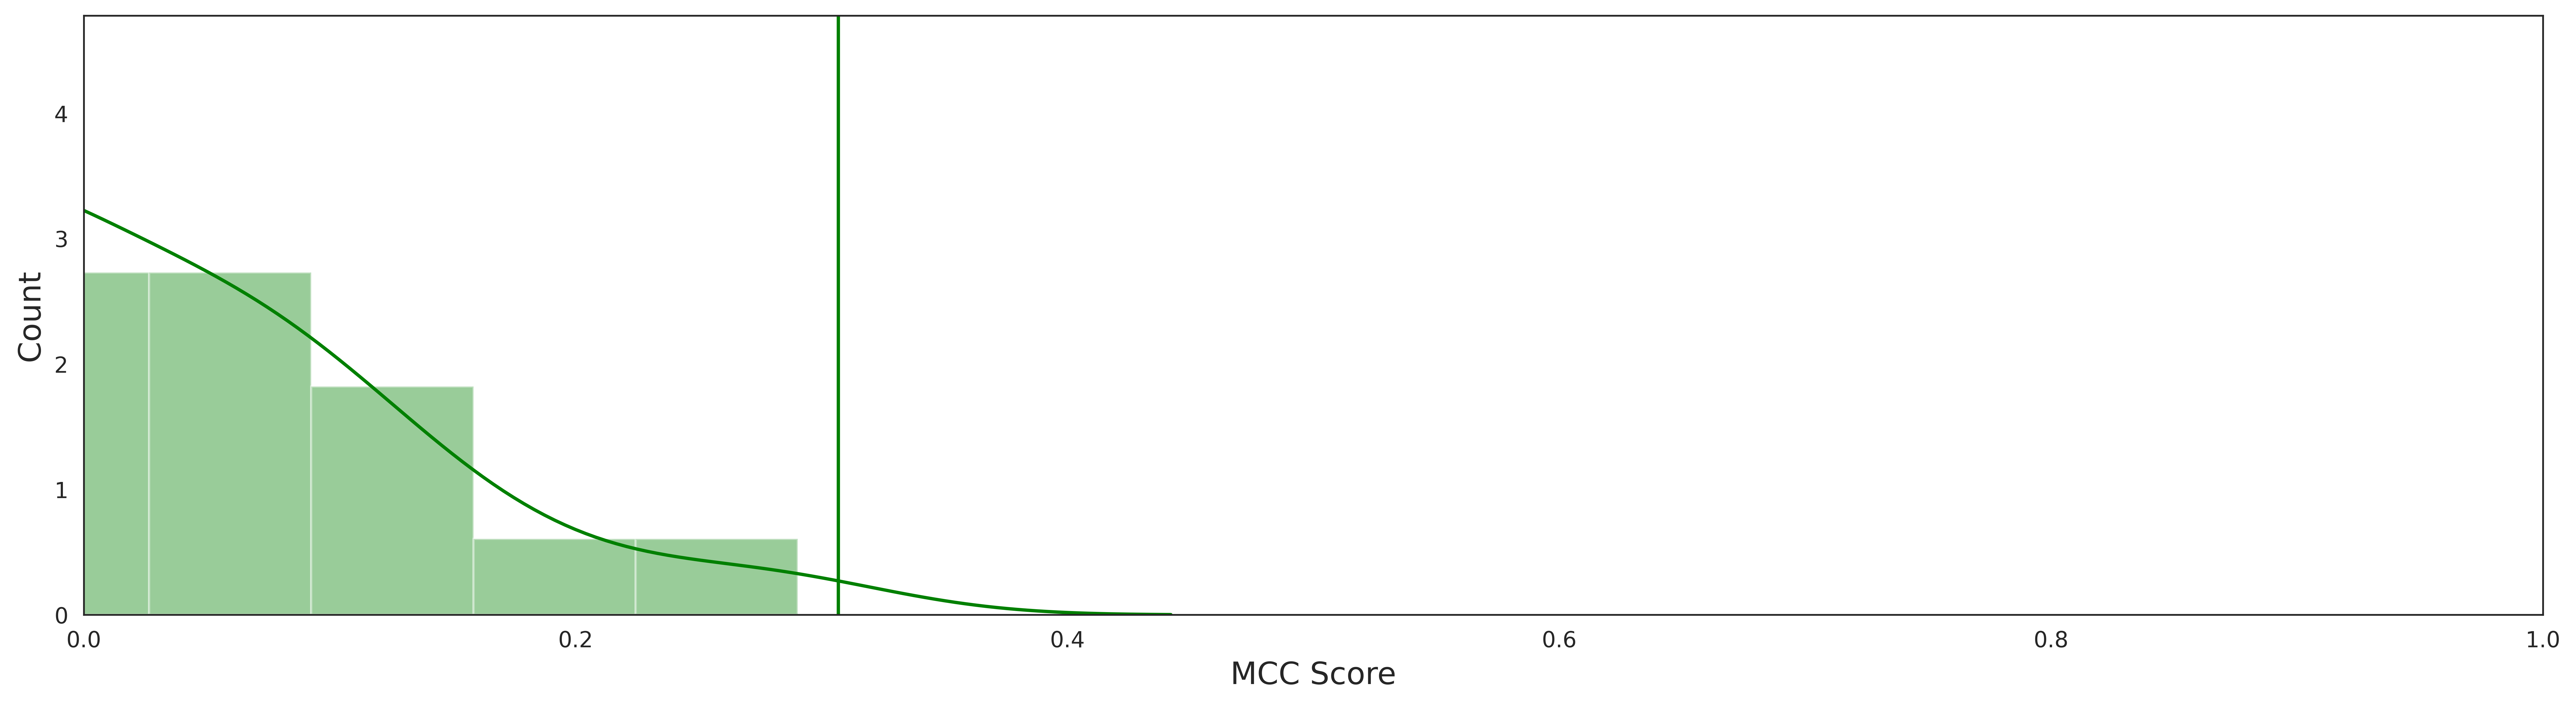

In [34]:
mcc2 = matthews_corrcoef(Y_v_test_data, scrmb_predictions)
sns.set_style("white")
plt.figure(figsize = (20, 5), dpi=600) 
ax = sns.distplot(mcc_list, color="green")
plt.axvline(mcc, color="green")
plt.xlabel("MCC Score", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
ax.set(xlim=(0, 1))
#plt.savefig('CB_MCC_plot.png', dpi=600, bbox_inches='tight')

In [4]:
mcc_list =[0.12288626446650694,
 -0.0902516423675028,
 -0.062144208145111623,
 0.1699739438097293,
 -0.07147368561733458,
 -0.05459913843599923,
 0.007078514210700635,
 -0.006454619206385499,
 -0.05266936711731326,
 -0.04232524226593973,
 0.09944853660409758,
 -0.09776602586976661,
 -0.00586679407988264,
 -0.014855607819639249,
 -0.23719585007199015,
 0.04388898232792991,
 -0.10293374908911611,
 -0.062144208145111623,
 0.10330172657299204,
 0.2904115485920181,
 -0.06902508580476474,
 -0.16200065903386074,
 0.10330172657299204,
 -0.1525702115702719,
 0.03885995659916373,
 0.07971693270065121,
 0.14635043026207184,
 0.11129891324694435,
 0.060747814742744356,
 -0.1238346480989226,
 0.0072489767514219115,
 0.25976626700404515,
 -0.09065018003004607,
 -0.056853304508625795,
 0.02515463444851046,
 -0.07223152589571286,
 0.1937484309812949,
 0.08199507134516071,
 0.0409400195574419,
 -0.010675431515458128,
 -0.06905895053803543,
 -0.1131725533831616,
 -0.027016035343457957,
 0.027217830826189778,
 0.04776761230242614,
 -0.056853304508625795,
 -0.1298422717801334,
 0.06911719271643117,
 -0.19935231197235764,
 -0.022819644030944396]
def Average(lst):
    return sum(lst) / len(lst)
#print(mcc_list)
average = Average(mcc_list)
  
# Printing average of the list
print("Average of the mcc list =", round(average, 3))

Average of the mcc list = -0.003


In [3]:
accuracy_list =[0.556892111683383,
 0.5925047438330171,
 0.608464353483329,
 0.4491562754133912,
 0.47536595283274596,
 0.4878015722417999,
 0.5017619951206289,
 0.5467945242613174,
 0.5745290051504474,
 0.4600840336134454,
 0.436212388181079,
 0.49552724315532665,
 0.39975264299268093,
 0.4295032529140688,
 0.545608566007048,
 0.6190532664678775,
 0.49688262401734884,
 0.5730042016806722,
 0.4449545947411222,
 0.49891569531038216,
 0.5188906207644348,
 0.5605855245323936,
 0.4578984819734345,
 0.39001084304689615,
 0.5357142857142857,
 0.4392450528598536,
 0.6126660341555978,
 0.5143500948766603,
 0.5084880726484142,
 0.4432773109243697,
 0.4136961236107346,
 0.5501660341555977,
 0.47033410138248843,
 0.5973841149362971,
 0.5007624017348875,
 0.4898346435348333,
 0.5568751694226077,
 0.5105042016806722,
 0.44764841420439144,
 0.4891569531038222,
 0.4061398753049607,
 0.4132047980482515,
 0.48898753049606936,
 0.5024227432908648,
 0.5115037950664137,
 0.5308349146110056,
 0.38177690431011113,
 0.45620425589590674,
 0.48024532393602604,
 0.5358667660612633]
def Average(lst):
    return sum(lst) / len(lst)
#print(mcc_list)
average = Average(accuracy_list)
  
# Printing average of the list
print("Average of the accuracy list =", round(average, 3))

Average of the accuracy list = 0.498


In [ ]:
external_data = pd.read_csv("IND_07-09-2022_morgan_chiral_1024FP.csv")
data_for_screening = pd.DataFrame(external_data)

In [ ]:
test_prob = ens.predict_proba(data_for_screening)
test_prob_F = pd.DataFrame(test_prob)
test_prob_F.to_csv('ENS1024_probability_FP.csv')